В таблице приведены покупки держателей карты. Описание параметров приведено на 
отдельном листе.

```
tran_dttm -	дата транзакции
tran_amt -	сумма 
disbursment_dt - дата открытия счета
customer_rk - уникальный id клиента
limit -	кредитный лимит по карте
caption - магазин, где была совершена транзакция
```


```
Необходимо:

·         определить наличие зависимости поведения клиента от места/суммы первой покупки.

In [33]:
import pandas as pd
import plotly_express as px

In [2]:
df = pd.read_excel('Источник/Решение Задание 1. Тест_сегменты Часть 2.xlsx')

In [3]:
#Просмотр данных: 
df.dtypes

TRAN_DTTM         datetime64[ns]
TRAN_AMT                 float64
DISBURSMENT_DT    datetime64[ns]
CUSTOMER_RK                int64
LIMIT                    float64
caption                   object
dtype: object

In [4]:
df.head()

,TRAN_DTTM,TRAN_AMT,DISBURSMENT_DT,CUSTOMER_RK,LIMIT,caption
0,2017-03-02 18:33:17,31.00,2017-03-01,14829027,15000.0,Пятерочка
1,2017-03-03 18:43:44,21.00,2017-03-01,14829027,15000.0,Пятерочка
2,2017-03-05 15:23:33,144.00,2017-03-03,4107662,15000.0,Успех
3,2017-03-07 11:17:26,1741.27,2017-03-03,4107662,15000.0,Новэкс
4,2017-03-18 13:04:13,6964.50,2017-03-06,39362150,0.0,Снежная Королева


In [39]:
# 1. ЗАВИСИМОСТЬ ПОВЕДЕНИЯ КЛИЕНТА ОТ МЕСТА
# Считаем активность клиентов по каждому месту
place_activity = df.groupby('caption').agg({
    'CUSTOMER_RK': 'nunique',  # количество уникальных клиентов
    'TRAN_AMT': ['count', 'sum', 'mean']  # количество, сумма, средний чек
}).round(2)

place_activity.columns = ['unique_customers', 'total_transactions', 'total_amount', 'avg_amount']
place_activity['transactions_per_customer'] = (place_activity['total_transactions'] / place_activity['unique_customers']).round(2)

print("ЗАВИСИМОСТЬ ПОВЕДЕНИЯ КЛИЕНТА ОТ МЕСТА (ТОП-10):")
print(place_activity.sort_values('transactions_per_customer', ascending=False).head(10))

# 2. ЗАВИСИМОСТЬ ПОВЕДЕНИЯ КЛИЕНТА ОТ СУММЫ ПЕРВОЙ ПОКУПКИ
# Находим первую покупку каждого клиента
first_purchases = df.loc[df.groupby('CUSTOMER_RK')['TRAN_DTTM'].idxmin()]
first_purchases = first_purchases[['CUSTOMER_RK', 'TRAN_AMT']].rename(columns={'TRAN_AMT': 'first_amount'})

# Считаем общее количество покупок каждого клиента
purchase_counts = df.groupby('CUSTOMER_RK').size().rename('total_purchases')

# Объединяем данные
analysis_df = first_purchases.merge(purchase_counts, on='CUSTOMER_RK')

# Категории по сумме первой покупки
analysis_df['amount_category'] = pd.cut(analysis_df['first_amount'], bins=3, labels=['Низкая', 'Средняя', 'Высокая'])

print("\n\nЗАВИСИМОСТЬ ПОВЕДЕНИЯ КЛИЕНТА ОТ СУММЫ ПЕРВОЙ ПОКУПКИ:")
print(analysis_df.groupby('amount_category')['total_purchases'].mean())

# Корреляция
print(f"\nКорреляция сумма-покупки: {analysis_df['first_amount'].corr(analysis_df['total_purchases']):.3f}")

ЗАВИСИМОСТЬ ПОВЕДЕНИЯ КЛИЕНТА ОТ МЕСТА (ТОП-10):
                                                 unique_customers  \
caption                                                             
МАГНИТ                                                          1   
Змеиногорское Районное Потребительское Общество                 1   
Аптечная сеть Здоровье                                          1   
Магазин Юлия                                                    1   
Магазин Счастливый                                              1   
Ярослав                                                         1   
МАРИЯ                                                           1   
КРЦ Империя                                                     1   
Магазин "РОЗТОР"                                                1   
Золотой ключик                                                  2   

                                                 total_transactions  \
caption                                            

C:\Users\Работа\AppData\Local\Temp\ipykernel_9704\1694669043.py:29: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



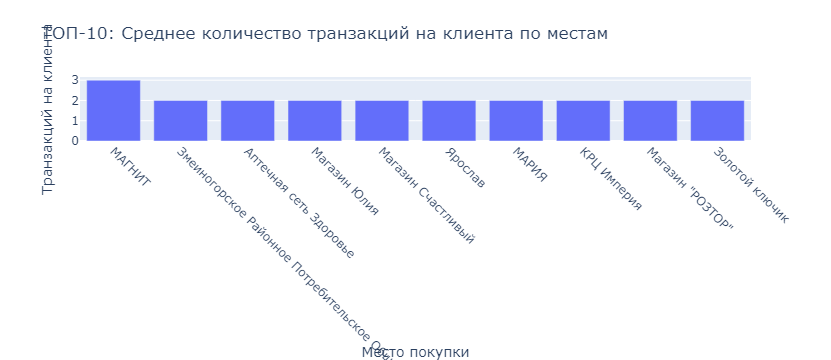

C:\Users\Работа\AppData\Local\Temp\ipykernel_9704\1556688228.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



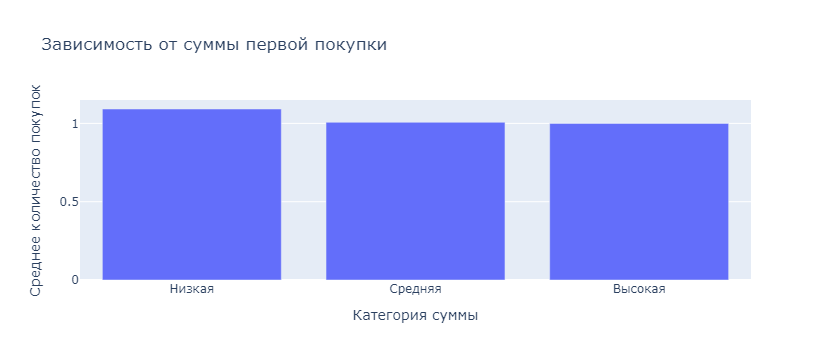

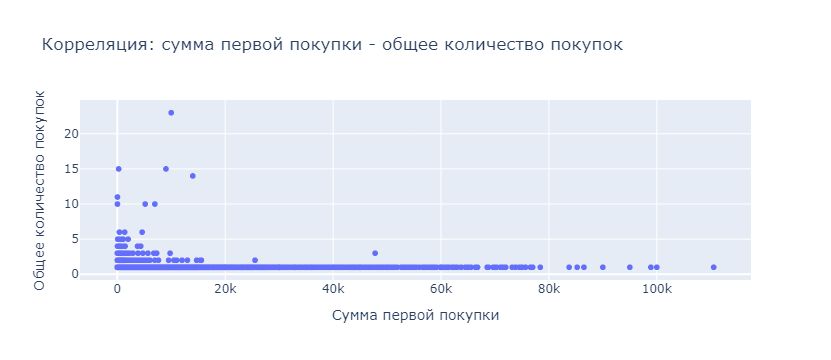

In [40]:
# ГРАФИКИ
# График 1: Место - транзакции на клиента (ТОП-10)
top_places = place_activity.sort_values('transactions_per_customer', ascending=False).head(10)
fig1 = px.bar(x=top_places.index, y=top_places['transactions_per_customer'],
              title='ТОП-10: Среднее количество транзакций на клиента по местам',
              labels={'x': 'Место покупки', 'y': 'Транзакций на клиента'})
fig1.update_xaxes(tickangle=45)
fig1.show()

# График 2: Сумма первой покупки
amount_data = analysis_df.groupby('amount_category')['total_purchases'].mean()
fig2 = px.bar(x=amount_data.index, y=amount_data.values,
              title='Зависимость от суммы первой покупки',
              labels={'x': 'Категория суммы', 'y': 'Среднее количество покупок'})
fig2.show()

# График 3: Корреляция
fig3 = px.scatter(analysis_df, x='first_amount', y='total_purchases',
                  title='Корреляция: сумма первой покупки - общее количество покупок',
                  labels={'first_amount': 'Сумма первой покупки', 'total_purchases': 'Общее количество покупок'})
fig3.show()